In [1]:
## PhysCat end of year project workspace

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import os
import random
import numba
from numba import vectorize, jit, njit


from scipy import interpolate

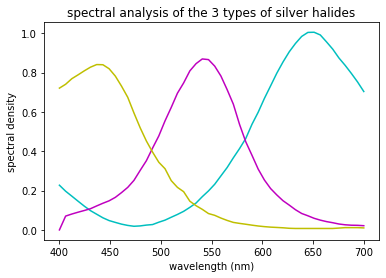

In [3]:
#making our spectral data sheet plots for the different silver halides
spec_data_cyan = np.array(pd.read_csv("spec_data_cyan.csv", header =[1]))
spec_data_magenta = np.array(pd.read_csv("spec_data_magenta.csv", header =[1]))
spec_data_yellow = np.array(pd.read_csv("spec_data_yellow.csv", header =[1]))

f_cyan = sp.interpolate.interp1d(spec_data_cyan[:, 0], spec_data_cyan[:, 1], bounds_error = False, fill_value = 0)
f_magenta = sp.interpolate.interp1d(spec_data_magenta[:, 0], spec_data_magenta[:, 1], bounds_error = False, fill_value = 0)
f_yellow = sp.interpolate.interp1d(spec_data_yellow[:, 0], spec_data_yellow[:, 1], bounds_error = False, fill_value = 0)

wavelengths = np.linspace(400, 700) #wavelengths is in nm
plt.figure()
plt.plot(wavelengths, f_cyan(wavelengths), 'c-')
plt.plot(wavelengths, f_magenta(wavelengths), 'm-')
plt.plot(wavelengths, f_yellow(wavelengths), 'y-')
plt.title('spectral analysis of the 3 types of silver halides')
plt.xlabel('wavelength (nm)')
plt.ylabel('spectral density')
plt.show()



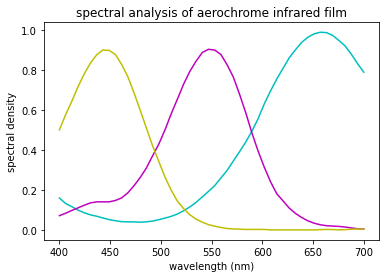

In [4]:
aero_cyan_data = np.array(pd.read_csv("aero_cyan_data.csv"))
aero_magenta_data = np.array(pd.read_csv("aero_magenta_data.csv"))
aero_yellow_data = np.array(pd.read_csv("aero_yellow_data.csv"))

f_cyan_aero = sp.interpolate.interp1d(aero_cyan_data[:, 0], aero_cyan_data[:, 1], bounds_error = False, fill_value = 0)
f_magenta_aero = sp.interpolate.interp1d(aero_magenta_data[:, 0], aero_magenta_data[:, 1], bounds_error = False, fill_value = 0)
f_yellow_aero = sp.interpolate.interp1d(aero_yellow_data[:, 0], aero_yellow_data[:, 1], bounds_error = False, fill_value = 0)

plt.figure()
plt.plot(wavelengths, f_cyan_aero(wavelengths), 'c-')
plt.plot(wavelengths, f_magenta_aero(wavelengths), 'm-')
plt.plot(wavelengths, f_yellow_aero(wavelengths), 'y-')
plt.title('spectral analysis of aerochrome infrared film')
plt.xlabel('wavelength (nm)')
plt.ylabel('spectral density')
plt.show()


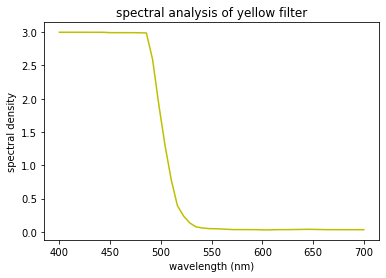

In [15]:
##making a yellow filter to put over the aerochrome

y_filter_data = np.array(pd.read_csv("y_filter_data.csv"))
f_yfilter = sp.interpolate.interp1d(y_filter_data[:, 0], y_filter_data[:, 1], bounds_error = False, fill_value = 0)

plt.figure()
plt.plot(wavelengths, f_yfilter(wavelengths), 'y-')
plt.title('spectral analysis of yellow filter')
plt.xlabel('wavelength (nm)')
plt.ylabel('spectral density')
plt.show()


In [6]:
#making it so each crystal hit by a light has some chance of being exposed to turn a magenta, cyan or yellow

@vectorize
def did_it_couple(f_spectral_val, intensity):
    if random.random() < f_spectral_val*intensity/65535:
        return True
    else: 
        return False
@jit
def compute_pixels(film, image, y_specval, c_specval, m_specval):
    for row in range(512):
            for col in range(512):
                film[row][col][0] += np.sum(np.array([did_it_couple(c_specval, image[row][col]) for _ in range(100)]))
                film[row][col][1] += np.sum(np.array([did_it_couple(m_specval, image[row][col]) for _ in range(100)]))
                film[row][col][2] += np.sum(np.array([did_it_couple(y_specval, image[row][col]) for _ in range(100)]))
    return film

def take_a_pic(image_folder, f_cyan, f_magenta, f_yellow):
    IMG = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".png"):
            im = np.array(imageio.imread(image_folder+"/"+filename))
            IMG.append(im)
    IMG = np.array(IMG)
    print(IMG.shape)
    film = np.zeros([512,512,3])
    for index, image in enumerate(IMG):
        wavelength = 400+index*10
        y_specval = f_yellow(wavelength)
        c_specval = f_cyan(wavelength)
        m_specval = f_magenta(wavelength)
        film = compute_pixels(film, image, y_specval, c_specval, m_specval)
        norm = np.max(film)/100
        film[::][::][0] += (1-film[::][::][0]/(100))
        film[::][::][1] += (1-film[::][::][1]/(100))
        film[::][::][2] += (1-film[::][::][2]/(100))
    return np.array(film)/(len(IMG)*norm)

In [7]:
film_glass_tiles = take_a_pic('glass_tiles_ms/glass_tiles_ms', f_cyan, f_magenta, f_yellow)

(31, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


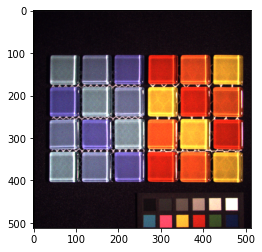

In [8]:
plt.imshow(film_glass_tiles)

In [9]:
aerochrome_glass_tiles = take_a_pic('glass_tiles_ms/glass_tiles_ms', f_cyan_aero, f_magenta_aero, f_yellow_aero)

(31, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


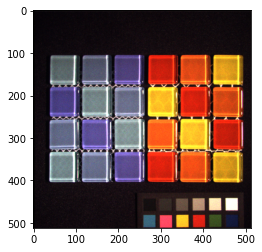

In [10]:
plt.imshow(aerochrome_glass_tiles)

In [11]:
film_thread = take_a_pic('thread_spools_ms/thread_spools_ms', f_cyan, f_magenta, f_yellow)
aerochrome_thread = take_a_pic('thread_spools_ms/thread_spools_ms', f_cyan_aero, f_magenta_aero, f_yellow_aero)

(31, 512, 512)
(31, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


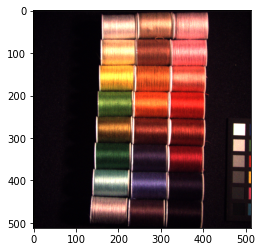

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


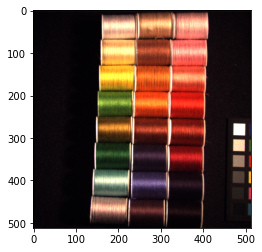

In [12]:
plt.figure()
plt.imshow(film_thread)
plt.show()
plt.figure()
plt.imshow(aerochrome_thread)
plt.show()

(31, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


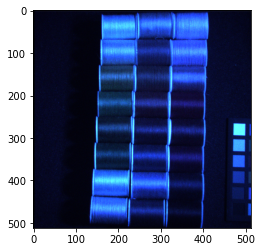

In [13]:
aerofilter_thread = take_a_pic('thread_spools_ms/thread_spools_ms', 
                               lambda x: f_cyan_aero(x)*f_yfilter(x),
                               lambda x: f_magenta_aero(x)*f_yfilter(x),
                               lambda x: f_yellow_aero(x)*f_yfilter(x))
plt.figure()
plt.imshow(aerofilter_thread)
plt.show()